SETUP

In [1]:
import numpy as np
import tensorflow as tf

from tensorflow import keras
import qkeras
from qkeras import *

2026-02-09 13:27:41.184806: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-09 13:27:41.249195: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-09 13:27:41.249241: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-09 13:27:41.250870: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-02-09 13:27:41.262543: I tensorflow/core/platform/cpu_feature_guar

In [2]:
X = np.load("bnb_WithWire_00_batch_00_40X192.npy")

In [3]:
X.shape

(1966080, 18, 16, 1)

In [4]:
from qkeras.utils import _add_supported_quantized_objects
co = {}
_add_supported_quantized_objects(co)

In [5]:
#model = keras.models.load_model("noQDB_seq", custom_objects=co)
teacher = keras.models.load_model('teacher_tiles40X192_sample')
student_test = qkeras.utils.load_qmodel('v1_12X12_40X192')

In [6]:
student_test.summary()

Model: "v1_12X12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_ (InputLayer)        [(None, 288)]             0         
                                                                 
 dense1 (QDenseBatchnorm)    (None, 16)                4689      
                                                                 
 relu1 (QActivation)         (None, 16)                0         
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense2 (QDense)             (None, 1)                 16        
                                                                 
 outputs (QActivation)       (None, 1)                 0         
                                                                 
Total params: 4705 (18.38 KB)
Trainable params: 4672 (18.2

In [7]:
import hls4ml
from QDenseBatchnorm import QDenseBatchnorm

In [8]:
import hls4ml.utils
import hls4ml.converters

In [9]:
config = hls4ml.utils.config_from_keras_model(student_test, backend='Vitis', 
                                              default_precision='fixed<32,16>',
                                              granularity='name')

Interpreting Model
Topology:
Layer name: inputs_, layer type: InputLayer, input shapes: [[None, 288]], output shape: [None, 288]
Layer name: dense1, layer type: QDenseBatchnorm, input shapes: [[None, 288]], output shape: [None, 16]
Layer name: relu1, layer type: Activation, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: dense2, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 1]
Layer name: outputs, layer type: Activation, input shapes: [[None, 1]], output shape: [None, 1]


/mnt/storage1/RAD/.conda/envs/hls_RAD/lib/python3.9/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [10]:
config

{'Model': {'Precision': 'fixed<32,16>',
  'ReuseFactor': 1,
  'Strategy': 'Latency',
  'BramFactor': 1000000000,
  'TraceOutput': False},
 'LayerName': {'inputs_': {'Trace': False,
   'Precision': {'result': 'fixed<32,16>'}},
  'dense1': {'Trace': False,
   'Precision': {'result': 'fixed<32,16>',
    'weight': 'fixed<16,5>',
    'bias': 'fixed<8,4>',
    'accum': 'fixed<32,16>'},
   'ReuseFactor': 1},
  'dense1_linear': {'Trace': False,
   'Precision': {'result': 'fixed<32,16>', 'table': 'fixed<18,8>'},
   'ReuseFactor': 1,
   'TableSize': 1024},
  'relu1': {'Trace': False,
   'Precision': {'result': 'ufixed<10,6,RND_CONV,SAT>',
    'table': 'fixed<18,8>'},
   'ReuseFactor': 1,
   'TableSize': 1024},
  'dense2': {'Trace': False,
   'Precision': {'result': 'fixed<32,16>',
    'weight': 'fixed<12,4>',
    'bias': 'fixed<32,16>',
    'accum': 'fixed<32,16>'},
   'ReuseFactor': 1},
  'dense2_linear': {'Trace': False,
   'Precision': {'result': 'fixed<32,16>', 'table': 'fixed<18,8>'},
   'R

In [11]:
hls_model = hls4ml.converters.convert_from_keras_model(student_test,
                                                       hls_config=config,
                                                       io_type='io_parallel',
                                                       backend = 'Vitis',
                                                       output_dir=f'v1_12X12_40X192_check')

Interpreting Model
Topology:
Layer name: inputs_, layer type: InputLayer, input shapes: [[None, 288]], output shape: [None, 288]
Layer name: dense1, layer type: QDenseBatchnorm, input shapes: [[None, 288]], output shape: [None, 16]
Layer name: relu1, layer type: Activation, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: dense2, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 1]
Layer name: outputs, layer type: Activation, input shapes: [[None, 1]], output shape: [None, 1]
Creating HLS model


In [12]:
X_flat = X.reshape((1966080,-1))

In [13]:
print(X_flat.shape)

(1966080, 288)


In [14]:
def loss(y_true, y_pred, choice):
    if choice == 'mse':
        loss = np.mean((y_true - y_pred)**2, axis = (1,2,3))
        return loss

ntimeticks = 6400
nwire = 3456
f_downsample = 10
h_split = 10
v_split = 4
nbatch = 32

strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

adccutoff = 10.*f_downsample/10.
adcsaturation = 100.*f_downsample/10.

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Number of devices: 1


COMPILING AND PREDICTING

In [15]:
#Y = student_test.predict(X_flat)

X_predict_teacher = teacher.predict(X)
X_loss_teacher = loss(X, X_predict_teacher, 'mse')
#X_student = X.reshape((-1,nwire*ntimeticks//f_downsample//v_split//h_split,1))
Y = student_test.predict(X_flat).reshape(len(X_loss_teacher))


61440/61440 [==============================] - 73s 1ms/step


In [16]:
hls_model.compile()

Writing HLS project


/mnt/storage1/RAD/.conda/envs/hls_RAD/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done


In [17]:
fake_hls4ml_pred, hls4ml_trace = hls_model.trace(X)

Recompiling myproject with tracing
Writing HLS project
Done


In [18]:
y_predict_hls4ml_q = hls_model.predict(X_flat).reshape(len(X_loss_teacher))

In [19]:
y_predict_hls4ml_q.shape

(1966080,)

In [20]:
import numpy as np

np.savetxt("bnb_WithWire_00_batch_00_40X192.dat", X_flat, fmt="%.8f", delimiter=" ")

np.savetxt("cicada_v1_12X12_40X192_preds.dat", y_predict_hls4ml_q, fmt="%.8f", delimiter=" ")

In [21]:
out_flat = np.loadtxt("output.dat")

out_flat.shape

(1966080,)

In [22]:
import matplotlib.pyplot as plt

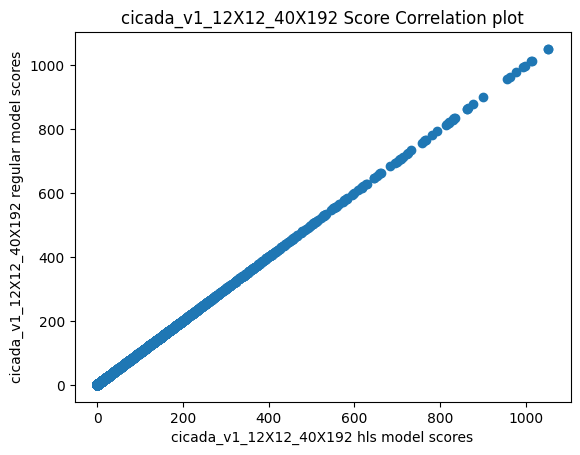

In [23]:
plt.scatter(y_predict_hls4ml_q, Y)
plt.xlabel('cicada_v1_12X12_40X192 hls model scores')
plt.ylabel('cicada_v1_12X12_40X192 regular model scores')
plt.title('cicada_v1_12X12_40X192 Score Correlation plot')
plt.show()

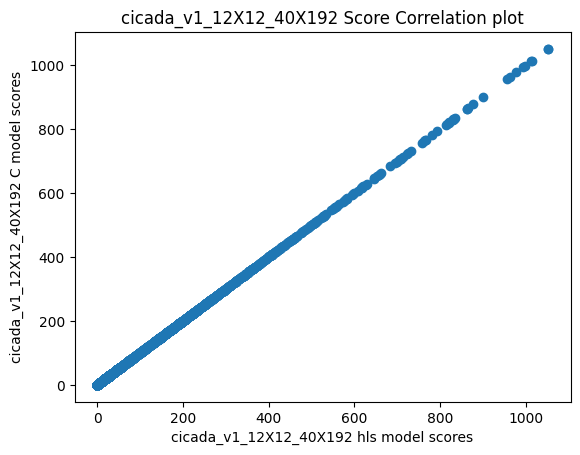

In [24]:
plt.scatter(y_predict_hls4ml_q, out_flat)
plt.xlabel('cicada_v1_12X12_40X192 hls model scores')
plt.ylabel('cicada_v1_12X12_40X192 C model scores')
plt.title('cicada_v1_12X12_40X192 Score Correlation plot')
plt.show()

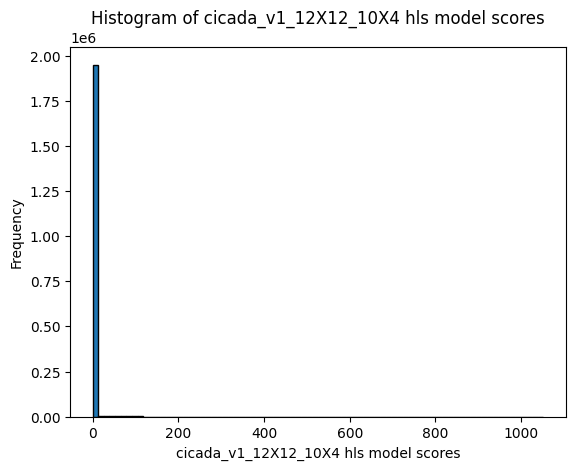

In [25]:
plt.hist(y_predict_hls4ml_q, bins=80, edgecolor='black')
plt.xlabel('cicada_v1_12X12_10X4 hls model scores')
plt.ylabel('Frequency')
plt.title('Histogram of cicada_v1_12X12_10X4 hls model scores')
plt.show()

In [26]:
off_list = np.argwhere(~np.isclose(Y, y_predict_hls4ml_q))

In [27]:
non_zero_list = np.argwhere(~np.isclose(0.0, y_predict_hls4ml_q))
non_zero_list_indexes = []
for k in non_zero_list:
    non_zero_list_indexes.append(k[0])

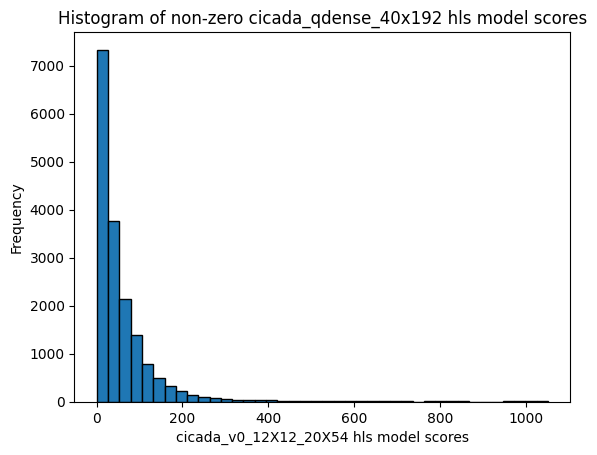

In [28]:
plt.hist(y_predict_hls4ml_q[non_zero_list_indexes], bins=40, edgecolor='black')
plt.xlabel('cicada_v0_12X12_20X54 hls model scores')
plt.ylabel('Frequency')
plt.title('Histogram of non-zero cicada_qdense_40x192 hls model scores')
plt.show()

In [29]:
len(off_list)

8814

In [30]:
len(non_zero_list)

17075

In [31]:
off_list_indexes = []
for k in off_list:
    off_list_indexes.append(k[0])

#for ind in off_list_indexes:
#    print("Y: ")
#    print(Y[ind])
#    print("hls pred: ")
#    print(y_predict_hls4ml_q[ind])

In [32]:
diff_sum=0
num_ones=0
for ind in off_list_indexes:
    diff = abs(Y[ind] - y_predict_hls4ml_q[ind])
    if diff==1:
        num_ones = num_ones+1
    diff_sum=diff_sum+diff
diff_avg = diff_sum/len(off_list)
print(diff_avg)
print(num_ones) #odd all differences are one

1.0
8814


In [33]:
diff_pct = []
for ind in off_list_indexes:
    diff = abs(Y[ind] - y_predict_hls4ml_q[ind])
    temp_diff_pct = diff/Y[ind]
    diff_pct.append(temp_diff_pct)
#print(diff_pct)

In [34]:
diff_pct_avg = sum(diff_pct)/len(diff_pct)
print(diff_pct_avg)

0.08712431893488033


In [35]:
np.allclose(Y, y_predict_hls4ml_q, atol=1)

True

WEIGHTS

Interpreting Model
Topology:
Layer name: inputs_, layer type: InputLayer, input shapes: [[None, 288]], output shape: [None, 288]
Layer name: dense1, layer type: QDenseBatchnorm, input shapes: [[None, 288]], output shape: [None, 16]
Layer name: relu1, layer type: Activation, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: dense2, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 1]
Layer name: outputs, layer type: Activation, input shapes: [[None, 1]], output shape: [None, 1]
Creating HLS model
Profiling weights (before optimization)
Weights for dense2 are only zeros, ignoring.
Profiling weights (final / after optimization)
Weights for dense2 are only zeros, ignoring.


(<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 None,
 None)

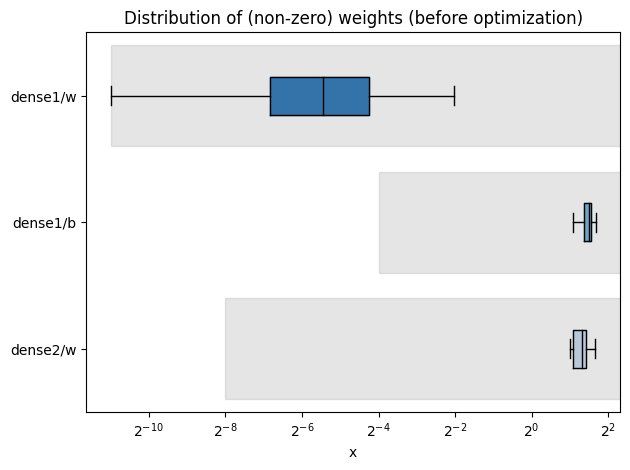

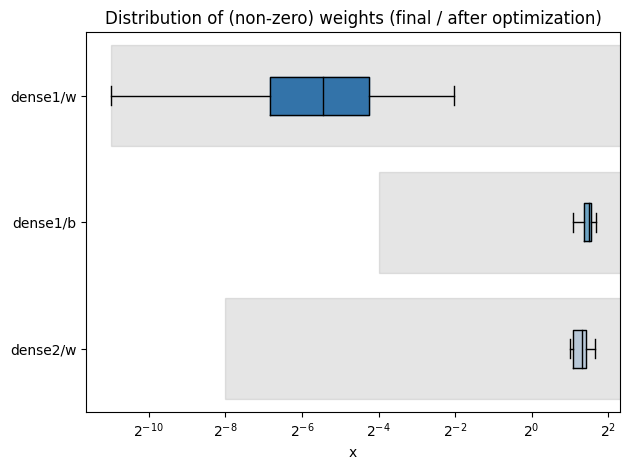

In [36]:
hls4ml.model.profiling.numerical(model=student_test, hls_model=hls_model)

In [37]:
layers = student_test.layers
print(layers)

[<keras.src.engine.input_layer.InputLayer object at 0x7fa54c4afb50>, <qkeras.qdense_batchnorm.QDenseBatchnorm object at 0x7fa544500700>, <qkeras.qlayers.QActivation object at 0x7fa544531a00>, <keras.src.layers.regularization.dropout.Dropout object at 0x7fa5445363a0>, <qkeras.qlayers.QDense object at 0x7fa544536e50>, <qkeras.qlayers.QActivation object at 0x7fa5444bd9a0>]


In [38]:
dense_weights = student_test.layers[5].get_weights()
print(dense_weights)

[]


In [39]:
for i, layer in enumerate(student_test.layers):
    print(layer)
    weights = layer.get_weights()
    for j,w in enumerate(weights):
        file_name = f"layer_{i}_weights_{j}.txt"
        if i!=1 and j!=4:
            np.savetxt(file_name, w, delimiter="\n")

In [40]:
hls_model.build(csim=False)


****** Vitis HLS - High-Level Synthesis from C, C++ and OpenCL v2023.1 (64-bit)
  **** SW Build 3854077 on May  4 2023
  **** IP Build 3864474 on Sun May  7 20:36:21 MDT 2023
  **** SharedData Build 3865790 on Sun May 07 13:33:03 MDT 2023
    ** Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.
    ** Copyright 2022-2023 Advanced Micro Devices, Inc. All Rights Reserved.

source /scratch/am_vitis/Vitis_HLS/2023.1/scripts/vitis_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/scratch/am_vitis/Vitis_HLS/2023.1/bin/unwrapped/lnx64.o/vitis_hls'
INFO: [HLS 200-10] For user 'RAD' on host 'cleopatra.nevis.columbia.edu' (Linux_x86_64 version 3.10.0-1160.31.1.el7.x86_64) on Mon Feb 09 14:12:29 EST 2026
INFO: [HLS 200-10] On os "CentOS Linux release 7.9.2009 (Core)"
INFO: [HLS 200-10] In directory '/mnt/storage1/RAD/v1_12X12_40X192_check'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-1510] Running: open_project myproject_prj 
INFO: [HLS 200-10] Creating and opening project '/mnt/storag

{'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '4.419',
  'BestLatency': '6',
  'WorstLatency': '6',
  'IntervalMin': '1',
  'IntervalMax': '1',
  'DSP': '5329',
  'FF': '127634',
  'LUT': '286856',
  'BRAM_18K': '0',
  'URAM': '0',
  'AvailableBRAM_18K': '5376',
  'AvailableDSP': '12288',
  'AvailableFF': '3456000',
  'AvailableLUT': '1728000',
  'AvailableURAM': '1280'}}